# Loan repayment predictor - Will our borrower pay the loan?
___

Financial lending is a risky field: granting a loan that will not be paid off can trigger great losses for the lender -even when the interest rate is high. In this project we will use machine learning algorithms to assist us in making those decisions: __Should we approve this loan request, based on the borrower's information?__

## Project goal
---
Using loan data from [Lending Club](https://www.lendingclub.com/), we will make predictions to answer the following question: __Will our borrower pay the loan?__

In order to achieve our goal, we will follow following workflow:
- Data exploration and understanding of each column
- Data cleaning
- Feature processing and selection
- Development of prediction models
- Error comparison and model selection

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<strong style="color:green">The raw code for this IPython notebook is by default hidden for easier reading.To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></strong>''')



In [2]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import pandas as pd # Data processing
pd.options.display.max_columns = 52

import numpy as np # Linear algebra

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind")

# Helper functions
def print_list(_list,title):
    print(title)
    print('-' * len(title))
    for item in _list:
        print('  - ', item)
        
def print_series(_series,title):
    print(title)
    print('-' * len(title))
    print(_series.to_string())

In [3]:
loans_2007 = pd.read_csv('loans_2007.csv')

## Data exploration
---

Before starting with the data cleaning process, we will identify columns with the following attributes:

- Columns that leak information from the future -to be avoided in our model
- Columns that don't impact the borrower's ability to pay off the loan
- Columns that need data cleaning
- Missing data
- Columns that can be combined
- Redundant columns

Our target column is `loan_status`. This column tells us wether the borrower completed the loan payment and under which circumstances.

For more understanding of our data, let's print the first 5 rows:

In [4]:
loans_2007.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9%,38.0,f,461.73,461.73,3581.120000,3581.12,2538.27,1042.85,0.00,0.00,0.00,Jun-2016,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [5]:
print('Number of rows: ',loans_2007.shape[0])
print('Number of columns: ',loans_2007.shape[1])

Number of rows:  42538
Number of columns:  52


## Data cleaning
---

### Eliminating irrelevant columns and treating missing values

In [6]:
relevant_columns = ['loan_amnt','term','int_rate','installment',
                   'emp_length','home_ownership','annual_inc',
                   'pymnt_plan','purpose','addr_state','delinq_2yrs',
                   'earliest_cr_line','inq_last_6mths',
                    'open_acc','pub_rec','total_acc','application_type',
                    'tax_liens','verification_status','title','dti',
                    'revol_bal','revol_util','last_credit_pull_d', 
                    'pub_rec_bankruptcies',                 
                    'loan_status' #target col
                   ]
# grade and sub_grade not included since they include redundant info from int_rate
# earliest_cr_line : create new feature: years since first credit line
#inq_last_ [6 and 12] months: figure sth out
relevant_columns
drop_columns = loans_2007.columns.difference(relevant_columns)
print_list(drop_columns.tolist(),'Columns to drop: 1st round')

Columns to drop: 1st round
--------------------------
  -  acc_now_delinq
  -  chargeoff_within_12_mths
  -  collection_recovery_fee
  -  collections_12_mths_ex_med
  -  delinq_amnt
  -  emp_title
  -  funded_amnt
  -  funded_amnt_inv
  -  grade
  -  id
  -  initial_list_status
  -  issue_d
  -  last_pymnt_amnt
  -  last_pymnt_d
  -  member_id
  -  out_prncp
  -  out_prncp_inv
  -  policy_code
  -  recoveries
  -  sub_grade
  -  total_pymnt
  -  total_pymnt_inv
  -  total_rec_int
  -  total_rec_late_fee
  -  total_rec_prncp
  -  zip_code


In [7]:
loans_2007=loans_2007.drop(drop_columns,axis=1) #drop columns

In [8]:
print_series(loans_2007['loan_status'].value_counts(),'Types of loan status - before filtering data')

Types of loan status - before filtering data
--------------------------------------------
Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3


In [9]:
# keep loans fully paid or charged off only
loans_2007 = loans_2007[
    (loans_2007['loan_status'] == 'Fully Paid') |
    (loans_2007['loan_status'] == 'Charged Off') 
     ]

# transform fully paid and charged off to numeric values
mapping_dict = {
    'loan_status': {
        'Fully Paid': 1,
        'Charged Off': 0
    }
}
loans_2007 = loans_2007.replace(mapping_dict)

print_series(loans_2007['loan_status'].value_counts(),'Types of loan status - fully paid = 1, charged off = 0')

Types of loan status - fully paid = 1, charged off = 0
------------------------------------------------------
1    33136
0     5634


There are way more paid off than charged off loans, which means that our model will tend to predict more 1 (paid off) loans than charged off - biased model.

In [10]:
# drop columns that contain only 1 unique value besides null

drop_columns = []

for col in loans_2007.columns:
    non_null_vals = loans_2007[col].dropna()
    unique_vals = non_null_vals.unique()
    num_unique_vals = len(unique_vals)
    if num_unique_vals == 1:
        drop_columns.append(col)

loans_2007 = loans_2007.drop(drop_columns,axis=1)

print_list(drop_columns,'Columns to drop: 2nd round: We will drop columns that have one unique value')

Columns to drop: 2nd round: We will drop columns that have one unique value
---------------------------------------------------------------------------
  -  pymnt_plan
  -  application_type
  -  tax_liens


In [11]:
null_vals = loans_2007.isnull().sum()

print_series(null_vals[null_vals > 0],'List of null values')

List of null values
-------------------
emp_length              1036
title                     11
revol_util                50
last_credit_pull_d         2
pub_rec_bankruptcies     697


In [12]:
print_series(loans_2007['pub_rec_bankruptcies'].value_counts(),'Value count: pub_rec_bankruptcies')

Value count: pub_rec_bankruptcies
---------------------------------
0.0    36422
1.0     1646
2.0        5


As we can see above, `pub_rec_bankruptcies` offers little to no variability. We'll drop this column.

In [13]:
loans_2007.drop(['pub_rec_bankruptcies'],axis=1,inplace=True)

In [14]:
print('Missing emp_length values: {:.2f}% of total values.'.format(
      100 * null_vals['emp_length']/len(loans_2007)))

Missing emp_length values: 2.67% of total values.


There are 1036 missing values in the column `emp_length`. Although we could impute these values using the mode, we can afford dropping all the rows with na values, since they represent less than a 3% of the total number of rows.

In [15]:
loans_2007.dropna(inplace=True)
loans_2007 = loans_2007.reset_index(drop=True) # reset indexes
print_series(loans_2007.isnull().sum(),"Missing values count - cleaned data")

Missing values count - cleaned data
-----------------------------------
loan_amnt              0
term                   0
int_rate               0
installment            0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
title                  0
addr_state             0
dti                    0
delinq_2yrs            0
earliest_cr_line       0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
last_credit_pull_d     0


## Feature processing and selection
---
Our machine learning model will only work with numeric columns. Since we have valuable columns with categorical values, we will proceed by creating dummy variables for these. We will also eliminate categorical features that contain an excesive number of unique values, since this would require too many dummy variables and would slow our model down.

In [16]:
print_series(loans_2007.dtypes.value_counts(),"Column types")

Column types
------------
object     11
float64    10
int64       1


In [17]:
object_cols_df = loans_2007.select_dtypes(include='object')
object_cols_df.head(1)

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016


As seen above, we have 11 columns that contain text values. We will proceed as follows:

__Drop columns:__

- `last_credit_pull_d`: Requires exhaustive feature engineering
- `addr_state`: Has too many values
- `title`': Has too many values
- `earliest_cr_line`: Requires exhaustive feature engineering

The rest of the columns will be treated, either switching the string values to numeric values (one number per value) or eliminating any unnecessary string values -i.e. percent symbol.

Our cleaned data, before creating dummy variables, looks as follows:

In [18]:
drop_cols = ['last_credit_pull_d', #requires exhaustive feature engineering
             'addr_state', #would require 49 dummy variables
             'title', #too many values
             'earliest_cr_line' #requires exhaustive feature engineering
            ]
loans_2007.drop(drop_cols,axis=1,inplace=True)

loans_2007['int_rate']=loans_2007['int_rate'].str.rstrip('%')
loans_2007['int_rate']=loans_2007['int_rate'].astype('float')

loans_2007['revol_util']=loans_2007['revol_util'].str.rstrip('%')
loans_2007['revol_util']=loans_2007['revol_util'].astype('float')

mapping_emp_length = { #converting to numeric values instead of categories
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans_2007=loans_2007.replace(mapping_emp_length)

loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000.0,36 months,10.65,162.87,10,RENT,24000.0,Verified,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0
1,2500.0,60 months,15.27,59.83,0,RENT,30000.0,Source Verified,0,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0
2,2400.0,36 months,15.96,84.33,10,RENT,12252.0,Not Verified,1,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0
3,10000.0,36 months,13.49,339.31,10,RENT,49200.0,Source Verified,1,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0
4,5000.0,36 months,7.90,156.46,3,RENT,36000.0,Source Verified,1,wedding,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0


### Creating dummy variables
We will create dummy variables for our categorical columns:
- `home_ownership`
- `verification_status`
- `purpose`
- `term`

Once we create them, we will drop the text columns.

In [19]:
dummy_df = pd.get_dummies(loans_2007[[
    'home_ownership', 'verification_status', 'purpose', 'term'
]])
loans_2007 = pd.concat([loans_2007,dummy_df],axis=1) #adding dummy cols to df

drop_cols = ['home_ownership', 'verification_status', 'purpose', 'term']
loans_2007.drop(drop_cols,axis=1, inplace=True) #drop text cols

## Development of prediction models
---

### Error metric

In [20]:
possibilities = {
    "loan_status": [0,0,1,1],
    "prediction": [1,0,1,0],
    "error": ["False Positive",
           "True Negative",
           "True Positive",
           "False Negative"]
}
print("Possible outcomes of a binary classification prediction:")
print("--------------------------------------------------------")
print(pd.DataFrame(possibilities).to_string(index=False))

Possible outcomes of a binary classification prediction:
--------------------------------------------------------
 loan_status  prediction           error
           0           1  False Positive
           0           0   True Negative
           1           1   True Positive
           1           0  False Negative


__Loan status - possible outcomes__
- 1: Loan will be paid off on time.
- 0: Loan will not be paid off on time.

__Prediction errors__
- *False Positive*: Our model predicts 1 (will be paid off on time) but the actual status is 0 (not paid off on time). __This is our worst case scenario, since this approving such a loan would make us lose money.__

- *False Negative*: Our model predicts 0 (not paid off on time) but the actual status is 1 (will be paid off on time). 

__Class imbalance__

Since we have way more loans that were paid off on time (1 values in our target column`loan_status`), our model will be more prone to predict that successful loan repayments - `prediction == 1`. For this reason, __using an accuracy score to measure the error is not the best approach__ - we will still compute this score and compare to our selected error scores.

In order to work around our class imbalance, we will penalize the rows with `loan_status == 1` by setting the `class_weight` parameter to `balanced` in our machine learning models. Our penalty will be inversely proportional to the class frequencies. We could also manipulate the weights manually if we wanted to adopt a more risky or conservative lending strategy.

We will look at following parameters as our error metric:

- *High [recall/True positive rate](https://en.wikipedia.org/wiki/Precision_and_recall#Recall)*: The higher our recall, the better our model will predict positive cases -we will grant more loans that will be paid off.

$
t_{pr} = t_p\frac1{t_p+t_n}\ \\
$

Where:

$t_{pr} := $ True positive rate

$t_p := $ True positive count

$t_n := $ True negative count


- *Low [fall-out/False positive rate](https://en.wikipedia.org/wiki/False_positive_rate)*: The lower our fall-out, the better our model will predict negative cases -we will reject more loans that would not be paid off. 

Optimizing these ratios will yield the highest chances of gaining (or not losing) money when using our model to approve or reject a loan. __We will prioritize minimizing the fall-out over the recall -conservative lending strategy.__

### Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

results = dict()

features = loans_2007.drop(['loan_status'],axis=1) # drop target column
target = loans_2007["loan_status"]

# Create a LogisticRegression instance 
# balanced class_weight will penalize loan_status = 1 -higher frequency
lr = LogisticRegression(class_weight='balanced')

k = 3

predictions = cross_val_predict(lr, features, target, cv=k)
predictions = pd.Series(predictions)

# True negatives
tn_bool_mask = loans_2007[(predictions == 0) & (loans_2007["loan_status"] == 0)]
tn = tn_bool_mask.shape[0]
# True positives
tp_bool_mask = loans_2007[(predictions == 1) & (loans_2007["loan_status"] == 1)]
tp = tp_bool_mask.shape[0]
# False negatives
fn_bool_mask = loans_2007[(predictions == 0) & (loans_2007["loan_status"] == 1)]
fn = fn_bool_mask.shape[0]
# False positives
fp_bool_mask = loans_2007[(predictions == 1) & (loans_2007["loan_status"] == 0)]
fp = fp_bool_mask.shape[0]

# Computing the true positive rate
tpr = tp/(tp+fn)

# Computing the false positive rate
fpr = fp/(fp + tn)

# Accuracy score - used only for model comparison purposes
accuracy = accuracy_score(loans_2007["loan_status"], predictions)

# Adding results to dictionary
results['indexes'] = ["True positive rate [%]","False positive rate [%]","Number of false positives","Accuracy score [%]"]
results['logistic_regression'] = [tpr,fpr,fp,accuracy]
results['logistic_regression'] = [round(value * 100,2) if value < 1 else value for value in results['logistic_regression']]

# Printing results
print("Logistic regression model, k = {}, class_weight = {}".format(k,'balanced'))
print("---------------------------------------------------------")
print("True positive rate: {:.2f}%".format(tpr*100))
print("False positive rate: {:.2f}%".format(fpr*100)) 
print("Number of false positives: {}".format(fp),
      'out of {} non-repayed loans'.format(loans_2007['loan_status'].value_counts().loc[0])) # total of loan_status == 0
print("Accuracy score: {:.2f}%".format(accuracy*100))

Logistic regression model, k = 3, class_weight = balanced
---------------------------------------------------------
True positive rate: 67.02%
False positive rate: 38.86%
Number of false positives: 2094 out of 5389 non-repayed loans
Accuracy score: 66.18%


### Random forest classifier model

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=1,class_weight='balanced')

predictions = cross_val_predict(rfc, features, target, cv=3)
predictions = pd.Series(predictions)

# True negatives
tn_bool_mask = loans_2007[(predictions == 0) & (loans_2007["loan_status"] == 0)]
tn = tn_bool_mask.shape[0]
# True positives
tp_bool_mask = loans_2007[(predictions == 1) & (loans_2007["loan_status"] == 1)]
tp = tp_bool_mask.shape[0]
# False negatives
fn_bool_mask = loans_2007[(predictions == 0) & (loans_2007["loan_status"] == 1)]
fn = fn_bool_mask.shape[0]
# False positives
fp_bool_mask = loans_2007[(predictions == 1) & (loans_2007["loan_status"] == 0)]
fp = fp_bool_mask.shape[0]

# Computing the true positive rate
tpr = tp/(tp+fn)

# Computing the false positive rate
fpr = fp/(fp + tn)

# Accuracy score - used only for model comparison purposes
accuracy = accuracy_score(loans_2007["loan_status"], predictions)

# Adding results to dictionary
results['random_forest_classifier'] = [tpr,fpr,fp,accuracy]
results['random_forest_classifier'] = [round(value * 100,2) if value < 1 else value for value in results['random_forest_classifier']]

# Printing results
print("Random forest classifier model, k = {}, class_weight = {}".format(k,'balanced'))
print("--------------------------------------------------------------")
print("True positive rate: {:.2f}%".format(tpr*100))
print("False positive rate: {:.2f}%".format(fpr*100)) 
print("Number of false positives: {}".format(fp),
      'out of {} non-repayed loans'.format(loans_2007['loan_status'].value_counts().loc[0])) # total of loan_status == 0
print("Accuracy score: {:.2f}%".format(accuracy*100))

Random forest classifier model, k = 3, class_weight = balanced
--------------------------------------------------------------
True positive rate: 97.01%
False positive rate: 91.82%
Number of false positives: 4948 out of 5389 non-repayed loans
Accuracy score: 84.30%


## Error comparison and model selection
---
As seen in the summary, our random forest classifier has a higher accuracy score and true positive rate. However, the number of false positives is inadmissible (4948 out of 5389 values). This means that our random forest classifier would approve loans to borrowers with similar attributes to most of the borrowers who did not repay their loan.

For this reason, __the logistic regression model is a better option__, since the number of false positives is lower (2094 out of 5389 values) and reduces considerably our chances of losing money. This is relative, since at the same time we will be rejecting loans that would be repayed, but approving one loan that will not be repayed (false positive) makes us lose more money than rejecting one loan that would have been repayed (false negative).

With this model, we could deploy a simple web app where lenders can enter the potential borrower's data and predict whether the loan will be repayed or not.

### Summary of results

In [23]:
results_df = pd.DataFrame(results).set_index('indexes').T
results_df

indexes,True positive rate [%],False positive rate [%],Number of false positives,Accuracy score [%]
logistic_regression,67.02,38.86,2094.0,66.18
random_forest_classifier,97.01,91.82,4948.0,84.30


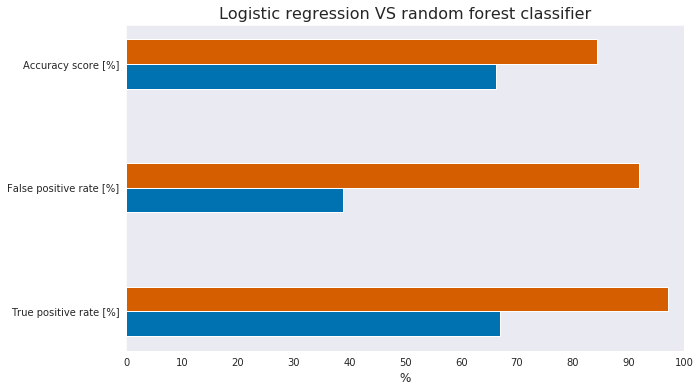

In [108]:
results_ratios = results_df.drop(['Number of false positives'],axis=1);
sns.set_style('dark');


bar_width = 0.2;
bar_colors = ['#0072b2','#d55e00'];
fig, ax = plt.subplots(figsize=(10,6));
ax.set_xlabel('%',fontsize=12);
ax.set_yticks(np.arange(3));
ax.set_yticklabels(results_ratios.columns);
ax.set_xlim([0,100]);
ax.set_xticks(np.arange(0,101,10));
for i in range(2):
    bar_position = np.arange(len(results_ratios.iloc[i]))-bar_width/2;
    ax.barh(bar_position + i*bar_width,results_ratios.iloc[i],bar_width,align='center',label=results_ratios.index[i],color=bar_colors[i])
    pass;
ax.set_title('Logistic regression VS random forest classifier',fontsize=16);
# ax.legend(bbox_to_anchor=(1.0,1));
plt.show()